# Body movement prediction
### _Hung Dinh_
### _October 13, 2018_

# 1. Summary

With various wearable devices, it is now possible to collect a large amount of data about personal activity relatively inexpensively. The data in this project is measured from accelerometers on the belt, forearm, arm, and dumbell of 6 participants (http://groupware.les.inf.puc-rio.br/har). They were asked to perform barbell lifts correctly and incorrectly in 5 different ways.The goal of your project is to predict the manner in which they did the exercise. This is the “classe” variable in the training set. The work was done firstly by Velloso, E.; Bulling, A.; Gellersen, H.; Ugulino, W.; Fuks, H., 2013.

The project includes some intuitions into the data, exploratory analysis, actual prediction prediction and interpretation.

My cross validation approach is using random subsampling into training and validating sets. I try 3 different prediction methods, namely Decision tree, Random forest, and Gradient boosting machine (gbm) with and without principle component analysis (PCA). The results show that Random forest is the best method on this data with validation accuracy of 99%.

# 2. Some details on the data and initial thoughts

According to the dataset description, four sensors are attached to: arm (bicep/tricep), forearm (on glove, close to the wrist), belt, and weight (dumbbell) during excerises.

In the dataset, there are five types of movements, labeled as follow:

- A: correct movement

- B: throwing elbows to the front

- C: lift up 1/2

- D: lower down 1/2

- E: throwing hip to the front

In order to classify these movements, based on the sensor position, here are my initial thoughts:

- since the forearm and weight sensors are close together, their measurements should be similar (except the weight measurements have more torque / twist movements)

- class E should be separated by hip-sensor measurements

- class B should be separated by arm measurements (X, Y, Z)

- classes A, C, D should be separated by forearm and weight measurements

- some classification methods: tree-based, SVM (KNN for clustering, complicated NN maybe later)

Let's start with the data and see how the problem is actually solved.

# 3. Data exploratory and cleaning

## First, (install and) load library:

In [ ]:
# install.packages("doParallel")
# install.packages("e1071")
# install.packages("gbm")

In [1]:
set.seed(12345)
library(parallel); library(doParallel)
library(caret); library(e1071); library(gbm); library(randomForest)

Loading required package: foreach
Loading required package: iterators
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loaded gbm 2.1.5
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



## Now let's load the data

In [2]:
library("aws.s3")
obj <- get_object(
    object = "pml-training.csv",
    bucket = "bodymovement-donotdelete-pr-btewlok0gqofyo",
    key = "42d1b50383564178b26d7b1386c2f803",
    secret = "9950f177705f081860803bd7cd58753629f3d2fc642f5ad3",
    check_region = FALSE,
    base_url = "s3-api.us-geo.objectstorage.service.networklayer.com")

In [3]:
tr <- read.csv(text = rawToChar(obj), na.strings = c("NA",""," "))
head(tr)

X,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
1,carlitos,1323084231,788290,05/12/2011 11:23,no,11,1.41,8.07,-94.4,...,0.03,0.00,-0.02,192,203,-215,-17,654,476,A
2,carlitos,1323084231,808298,05/12/2011 11:23,no,11,1.41,8.07,-94.4,...,0.02,0.00,-0.02,192,203,-216,-18,661,473,A
3,carlitos,1323084231,820366,05/12/2011 11:23,no,11,1.42,8.07,-94.4,...,0.03,-0.02,0.00,196,204,-213,-18,658,469,A
4,carlitos,1323084232,120339,05/12/2011 11:23,no,12,1.48,8.05,-94.4,...,0.02,-0.02,0.00,189,206,-214,-16,658,469,A
5,carlitos,1323084232,196328,05/12/2011 11:23,no,12,1.48,8.07,-94.4,...,0.02,0.00,-0.02,189,206,-214,-17,655,473,A
6,carlitos,1323084232,304277,05/12/2011 11:23,no,12,1.45,8.06,-94.4,...,0.02,-0.02,-0.03,193,203,-215,-9,660,478,A


Here are all headers:

In [4]:
names(tr)


[1] "X"                        "user_name"               
  [3] "raw_timestamp_part_1"     "raw_timestamp_part_2"    
  [5] "cvtd_timestamp"           "new_window"              
  [7] "num_window"               "roll_belt"               
  [9] "pitch_belt"               "yaw_belt"                
 [11] "total_accel_belt"         "kurtosis_roll_belt"      
 [13] "kurtosis_picth_belt"      "kurtosis_yaw_belt"       
 [15] "skewness_roll_belt"       "skewness_roll_belt.1"    
 [17] "skewness_yaw_belt"        "max_roll_belt"           
 [19] "max_picth_belt"           "max_yaw_belt"            
 [21] "min_roll_belt"            "min_pitch_belt"          
 [23] "min_yaw_belt"             "amplitude_roll_belt"     
 [25] "amplitude_pitch_belt"     "amplitude_yaw_belt"      
 [27] "var_total_accel_belt"     "avg_roll_belt"           
 [29] "stddev_roll_belt"         "var_roll_belt"           
 [31] "avg_pitch_belt"           "stddev_pitch_belt"       
 [33] "var_pitch_belt"           "avg_yaw_belt"            
 [35] "stddev_yaw_belt"          "var_yaw_belt"            
 [37] "gyros_belt_x"             "gyros_belt_y"            
 [39] "gyros_belt_z"             "accel_belt_x"            
 [41] "accel_belt_y"             "accel_belt_z"            
 [43] "magnet_belt_x"            "magnet_belt_y"           
 [45] "magnet_belt_z"            "roll_arm"                
 [47] "pitch_arm"                "yaw_arm"                 
 [49] "total_accel_arm"          "var_accel_arm"           
 [51] "avg_roll_arm"             "stddev_roll_arm"         
 [53] "var_roll_arm"             "avg_pitch_arm"           
 [55] "stddev_pitch_arm"         "var_pitch_arm"           
 [57] "avg_yaw_arm"              "stddev_yaw_arm"          
 [59] "var_yaw_arm"              "gyros_arm_x"             
 [61] "gyros_arm_y"              "gyros_arm_z"             
 [63] "accel_arm_x"              "accel_arm_y"             
 [65] "accel_arm_z"              "magnet_arm_x"            
 [67] "magnet_arm_y"             "magnet_arm_z"            
 [69] "kurtosis_roll_arm"        "kurtosis_picth_arm"      
 [71] "kurtosis_yaw_arm"         "skewness_roll_arm"       
 [73] "skewness_pitch_arm"       "skewness_yaw_arm"        
 [75] "max_roll_arm"             "max_picth_arm"           
 [77] "max_yaw_arm"              "min_roll_arm"            
 [79] "min_pitch_arm"            "min_yaw_arm"             
 [81] "amplitude_roll_arm"       "amplitude_pitch_arm"     
 [83] "amplitude_yaw_arm"        "roll_dumbbell"           
 [85] "pitch_dumbbell"           "yaw_dumbbell"            
 [87] "kurtosis_roll_dumbbell"   "kurtosis_picth_dumbbell" 
 [89] "kurtosis_yaw_dumbbell"    "skewness_roll_dumbbell"  
 [91] "skewness_pitch_dumbbell"  "skewness_yaw_dumbbell"   
 [93] "max_roll_dumbbell"        "max_picth_dumbbell"      
 [95] "max_yaw_dumbbell"         "min_roll_dumbbell"       
 [97] "min_pitch_dumbbell"       "min_yaw_dumbbell"        
 [99] "amplitude_roll_dumbbell"  "amplitude_pitch_dumbbell"
[101] "amplitude_yaw_dumbbell"   "total_accel_dumbbell"    
[103] "var_accel_dumbbell"       "avg_roll_dumbbell"       
[105] "stddev_roll_dumbbell"     "var_roll_dumbbell"       
[107] "avg_pitch_dumbbell"       "stddev_pitch_dumbbell"   
[109] "var_pitch_dumbbell"       "avg_yaw_dumbbell"        
[111] "stddev_yaw_dumbbell"      "var_yaw_dumbbell"        
[113] "gyros_dumbbell_x"         "gyros_dumbbell_y"        
[115] "gyros_dumbbell_z"         "accel_dumbbell_x"        
[117] "accel_dumbbell_y"         "accel_dumbbell_z"        
[119] "magnet_dumbbell_x"        "magnet_dumbbell_y"       
[121] "magnet_dumbbell_z"        "roll_forearm"            
[123] "pitch_forearm"            "yaw_forearm"             
[125] "kurtosis_roll_forearm"    "kurtosis_picth_forearm"  
[127] "kurtosis_yaw_forearm"     "skewness_roll_forearm"   
[129] "skewness_pitch_forearm"   "skewness_yaw_forearm"    
[131] "max_roll_forearm"         "max_picth_forearm"       
[133] "max_yaw_forearm"          "min_roll

Look at the data size:

In [5]:
dim(tr)

[1] 19622   160

and a small portion of it:

In [6]:
head(tr[,5:15],3)

cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,kurtosis_yaw_belt,skewness_roll_belt
05/12/2011 11:23,no,11,1.41,8.07,-94.4,3,NA,NA,NA,NA
05/12/2011 11:23,no,11,1.41,8.07,-94.4,3,NA,NA,NA,NA
05/12/2011 11:23,no,11,1.42,8.07,-94.4,3,NA,NA,NA,NA


The data has 19622 observations of 160 variables (the last one is the outcome). There are some variables with many `NA`s. I also notice that `new_window` has 406 values of **yes**:

In [7]:
summary(tr$new_window)

no   yes 
19216   406

which corresponds to the number of `NA` in other variables, ie.:

In [8]:
summary(tr$kurtosis_yaw_belt)

#DIV/0!    NA's 
    406   19216

In [9]:
summary(tr$amplitude_yaw_belt)

#DIV/0!    0.00  0.0000    NA's 
     10      12     384   19216

Note that 19622 - 406 = 19216... interesting!

Let’s have a look at the some variables where `new_window` is **yes**

In [10]:
idx <- which(tr$new_window=='yes')[1:5]
tr[idx,c("new_window","kurtosis_roll_belt","kurtosis_yaw_belt","amplitude_yaw_belt","roll_belt","gyros_belt_x")]

,new_window,kurtosis_roll_belt,kurtosis_yaw_belt,amplitude_yaw_belt,roll_belt,gyros_belt_x
24,yes,5.587755,#DIV/0!,0.0000,1.51,0.02
52,yes,-0.997130,#DIV/0!,0.0000,1.27,0.00
76,yes,7.515290,#DIV/0!,0.0000,1.18,0.02
165,yes,-2.121212,#DIV/0!,0.0000,1.01,0.03
210,yes,-1.122273,#DIV/0!,0.0000,129.00,-0.43


and where `new_window` is **no**:

In [11]:
idx <- which(tr$new_window=='no')[1:5]
tr[idx,c("new_window","kurtosis_roll_belt","kurtosis_yaw_belt","amplitude_yaw_belt","roll_belt","gyros_belt_x")]

new_window,kurtosis_roll_belt,kurtosis_yaw_belt,amplitude_yaw_belt,roll_belt,gyros_belt_x
no,NA,NA,NA,1.41,0.00
no,NA,NA,NA,1.41,0.02
no,NA,NA,NA,1.42,0.00
no,NA,NA,NA,1.48,0.02
no,NA,NA,NA,1.48,0.02


Now we have a better understand about the data structure. This is how it looks like:

- A lot of variables contain mostly `NA`s (19216 times with `time_window` = **no**)
- In these variables, where the data is not `NA`, (406 times, with `time_window` = **yes**), some variables have problematic measurements. For example: `DIV/0`, `zeros`. These variables apparently are the one with `NA` problem.
- I think these variables have measurement error: normally they record nothing (`NA`s are for NA, or missing data, or space) or problematic numbers.

My strategy to clean the data: remove columns with mostly `NA`s

In [12]:
na_count <- data.frame(sapply(tr, function(tr) sum(length(which(is.na(tr))))))
skipcol <- na_count == 19216
skipcol <- as.logical(skipcol)
tr1 <- tr[, -which(skipcol == 1)]
dim(tr1)

[1] 19622    60

The data now has 60 variables. Let’s have a look at some variables:

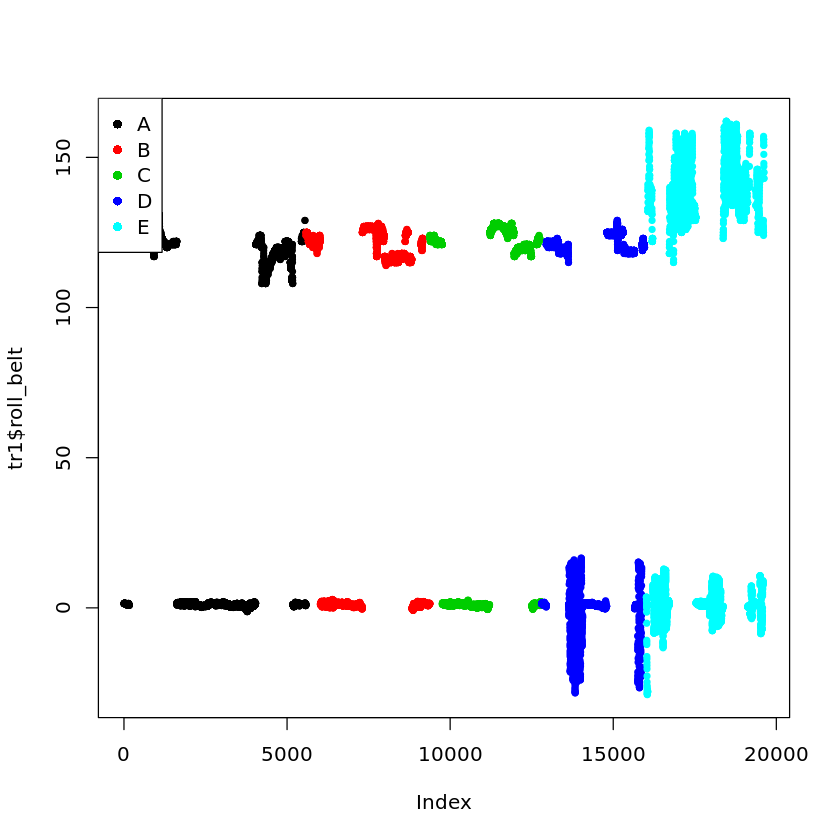

In [13]:
wtype <- as.factor(tr1[,60]) #last header is the class
plot(tr1$roll_belt, pch=20, col=wtype)
legend("topleft", legend=levels(wtype), pch=16, col=unique(wtype))

The data seems to be sorted by class. I now plot all data to see if any variable could be factorized. A boxplot is useful to detect outlier but a regular plot even shows outliers better and indicate factorable variables:

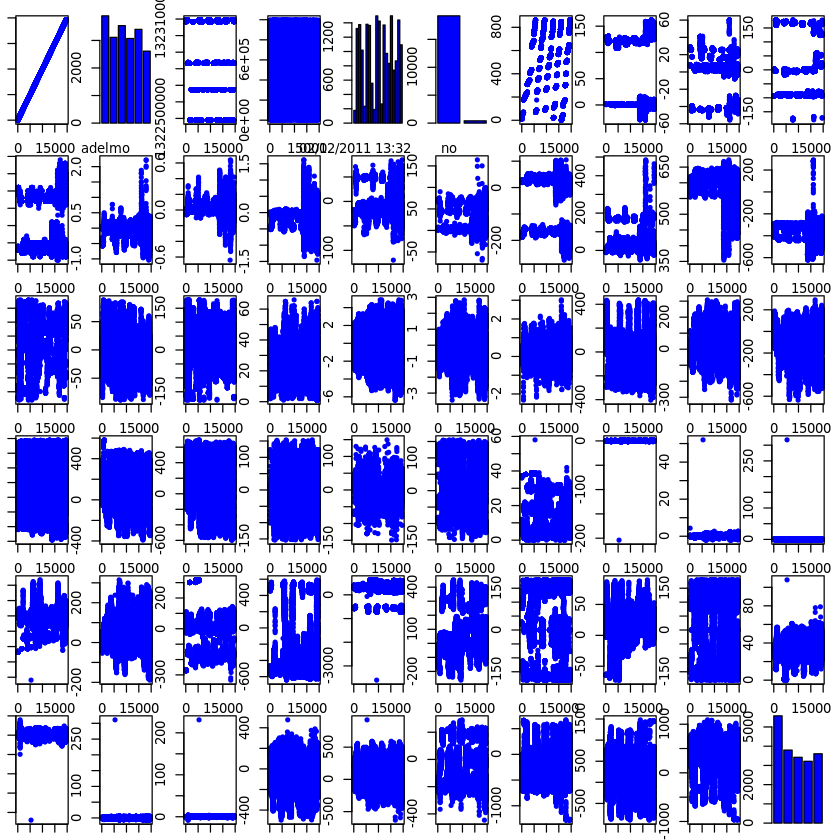

In [14]:
par(mfrow = c(6,10), mar=c(1,1,1,1))
for (i in 1:60)
{
    plot(tr1[,i], pch=20, col="blue")
}

We can see some outliers in the data at variables 38, 39, 40, 45, 51, 52, 53. I will remove the points which is beyond 75th accummulated quantile from the data, then remove the first 7 variables that have nothing to do in prediction (time and index).

In [15]:
ol38<-as.numeric(tr1$gyros_dumbbell_x<(quantile(tr1$gyros_dumbbell_x)[1]+quantile(tr1$gyros_dumbbell_x)[2])/2)
ol39<-as.numeric(tr1$gyros_dumbbell_y>(quantile(tr1$gyros_dumbbell_y)[4]+quantile(tr1$gyros_dumbbell_y)[5])/2)
ol40<-as.numeric(tr1$gyros_dumbbell_z>(quantile(tr1$gyros_dumbbell_z)[4]+quantile(tr1$gyros_dumbbell_z)[5])/2)
ol45<-as.numeric(tr1$magnet_dumbbell_y<(quantile(tr1$magnet_dumbbell_y)[1]+quantile(tr1$magnet_dumbbell_y)[2])/2)
ol51<-as.numeric(tr1$gyros_forearm_x<(quantile(tr1$gyros_forearm_x)[1]+quantile(tr1$gyros_forearm_x)[2])/2)
ol52<-as.numeric(tr1$gyros_forearm_y>(quantile(tr1$gyros_forearm_y)[4]+quantile(tr1$gyros_forearm_y)[5])/2)
ol53<-as.numeric(tr1$gyros_forearm_z>(quantile(tr1$gyros_forearm_z)[4]+quantile(tr1$gyros_forearm_z)[5])/2)

skiprow <- ol38 + ol39 + ol40 + ol45 + ol51 + ol52 + ol53

tr2 <- tr1[-which(skiprow > 0),]

dim(tr2)

[1] 19620    60

The data now has 19620 observations of 60 variables (the last column is the outcome). Let’s have a look at the data again, with color of classes:

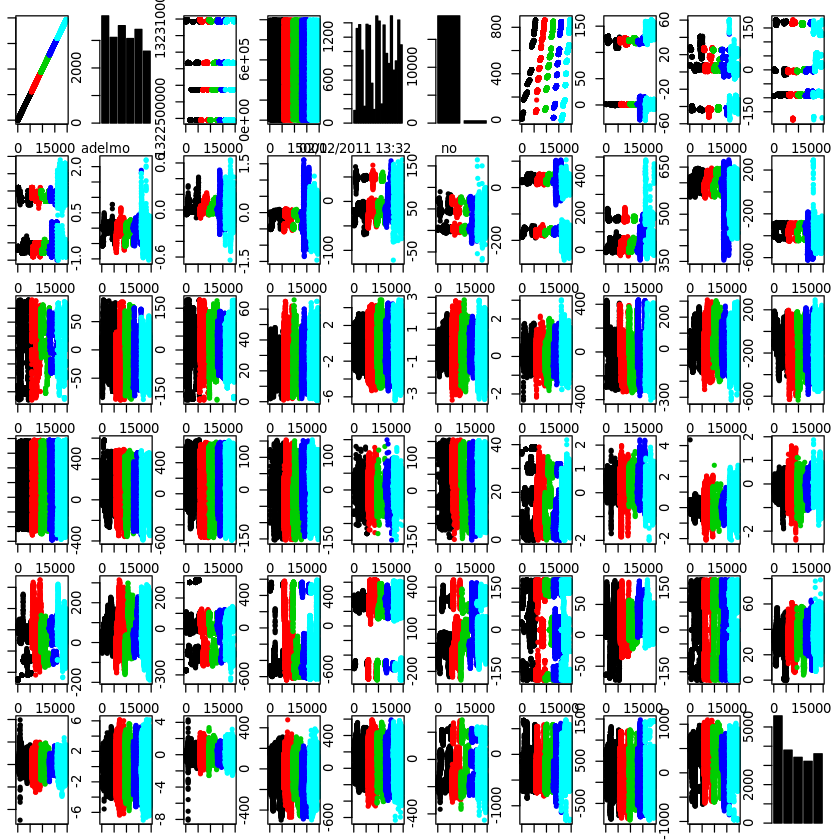

In [16]:
par(mfrow = c(6,10), mar=c(1,1,1,1))
for (i in 1:60)
{
    plot(tr2[,i], pch=20, col=wtype)
}

Now there is no outlier, so we don’t miss anything.

Clearly now the data is sorted by classes (plots 1, 4, 60). Probably when measuring, the volunteers were asked to do a certain type of movement before moving to the others. They also indicate that the classes are not skewed.

Now let me remove the first 7 variables: timing and volunteer object.

In [17]:
tr4 <- tr2[,-c(1:7)]
dim(tr4)

[1] 19620    53

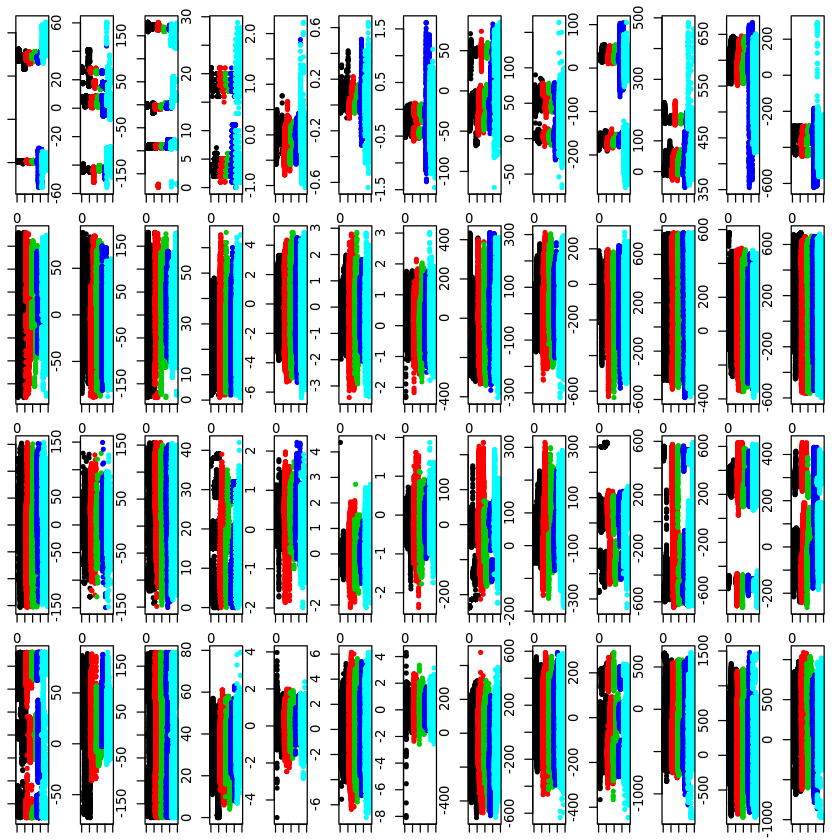

In [18]:
par(mfrow = c(4,13), mar=c(1,1,1,1))
for (i in 1:52)
{
    plot(tr4[,i], pch=20, col=wtype)
}

In [19]:
names(tr4)

[1] "roll_belt"            "pitch_belt"           "yaw_belt"            
 [4] "total_accel_belt"     "gyros_belt_x"         "gyros_belt_y"        
 [7] "gyros_belt_z"         "accel_belt_x"         "accel_belt_y"        
[10] "accel_belt_z"         "magnet_belt_x"        "magnet_belt_y"       
[13] "magnet_belt_z"        "roll_arm"             "pitch_arm"           
[16] "yaw_arm"              "total_accel_arm"      "gyros_arm_x"         
[19] "gyros_arm_y"          "gyros_arm_z"          "accel_arm_x"         
[22] "accel_arm_y"          "accel_arm_z"          "magnet_arm_x"        
[25] "magnet_arm_y"         "magnet_arm_z"         "roll_dumbbell"       
[28] "pitch_dumbbell"       "yaw_dumbbell"         "total_accel_dumbbell"
[31] "gyros_dumbbell_x"     "gyros_dumbbell_y"     "gyros_dumbbell_z"    
[34] "accel_dumbbell_x"     "accel_dumbbell_y"     "accel_dumbbell_z"    
[37] "magnet_dumbbell_x"    "magnet_dumbbell_y"    "magnet_dumbbell_z"   
[40] "roll_forearm"         "pitch_forearm"        "yaw_forearm"         
[43] "total_accel_forearm"  "gyros_forearm_x"      "gyros_forearm_y"     
[46] "gyros_forearm_z"      "accel_forearm_x"      "accel_forearm_y"     
[49] "accel_forearm_z"      "magnet_forearm_x"     "magnet_forearm_y"    
[52] "magnet_forearm_z"     "classe"

The data now has 19620 observations of 53 variables (the last column is the outcome). Each sensor has 13 measurements and are displayed at each row, the order is: `belt`, `arm`, `dumbbell`, and `forearm`.

## Findings

- If we look closely to the plots, we can see that my initial thoughts of separating different classes do not work. There is no separation in any variable betwen the classes.

- In terms of the amplitude ranges of measurements:
    - Belt measurement value ranges are separated from the other three sensors
    - Forearm and dumbbell measurements (last and second last rows) seem to be not similar
    - Forearm and arm measurements are more similar, especially in `total_accel`, `gyros_z`, `accel_x`, `accel_z`.
    - If the data is written correctly, my intuition was wrong, and that’s important to not trusting the gut.

# 4. Cross validation and data preprocessing

I divide the training data into 3 parts: training, validation and test sets (random subsampling).

Since the sample size is moderate (about 20,000 samples), my dividing percentage ratio between training/validation/test samples is: 60/20/20.

In [20]:
inTrain <- createDataPartition(y=tr4$classe, p = 0.6, list=FALSE)
tr4tr <- tr4[inTrain, ]
tr4tmp <- tr4[-inTrain, ]
inVal <- createDataPartition(y=tr4tmp$classe, p = 0.5, list=FALSE)
tr4val <- tr4tmp[inVal, ]
tr4test <- tr4tmp[-inVal, ]

Now I normalize the data (actually this is not required when using tree-based methods but as a habit, I usually normalize the data before feeding it to any model).

In [21]:
preprocess <- preProcess(tr4tr, method = c("center", "scale"))   # build the preprocess "template"
tr4trp <- predict(preprocess, tr4tr)                             # apply the template on the training set
tr4valp <- predict(preprocess, tr4val)                           # apply the template on the validation set
tr4testp <- predict(preprocess, tr4test)                         # apply the template on the test set

# 5. Analysis strategy

I will train different models using training set. Three models will be tested:

- Decision tree

- Random forest (RF)

- Gradient boosting machine (GBM).

Decision tree is tested but I’m afraid it won’t perform very well. Other methods may be better but is harder to interpret.

For demonstration, they are trained without parameter tuning. Keep in mind that the more sophisticated GBM performs better than simple RF if being tuned properly. However RF can be paralleled while GBM theoretically can not.

Notes:
- Resampling: from boostrapping to k-fold cross-validation.
- Parallelization: because trees are selected independently (unlike GBM where a tree depends on the previous ones), this will help to reduce computing time.

These trained models are then applied on the validation set. I will then pick the best model based on its accuracy performance on the validation set. Please note that model optimization and tuning is not focused on this project. So, most of the model parameters are kept as default.

Because training is time consuming, I extend the project by applying principal component analysis (PCA) before model training. PC transformation is applied on the training data so that 90% of the variance is preserved, then the transformed PC will be used to train, using the best methods seclected before.

At the end, I will compare all methods, in terms of performance and time duration. The best one will be applied on the test set for prediction.

In [22]:
fitControl <- trainControl(method = "cv", number = 5, allowParallel = TRUE)

In [23]:
conMtxPlot <- function(a){
    a <- prop.table(a,2)
    name <- c("A","B","C","D","E")
    conf <- as.data.frame(as.table(a))
    plot <- ggplot(conf)
    plot + geom_tile(aes(x=Reference, y = Prediction, fill=Freq))+
            scale_x_discrete(name = "Actual Class") + 
            scale_y_discrete(name="Predicted class") + 
            scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2)) + 
            labs(fill="Normalized\nFrequency") +
            geom_text(aes(x =Reference , y=Prediction, label = sprintf("%1.2f",Freq)), vjust = 1)
}

_The next cell turns on parallel computation_

In [24]:
# cluster <- makeCluster(detectCores()-1) 
cluster <- makeCluster(7)
registerDoParallel(cluster)

# 6. Train and validate models without PCA
## 6.1. Decision tree

Time difference of 1.468481 secs

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1015   38   31   24    8
         B  124  491   80   36   28
         C   20   67  532   45   20
         D   56   73   76  359   79
         E   17   63   74   42  525

Overall Statistics
                                          
               Accuracy : 0.7448          
                 95% CI : (0.7309, 0.7584)
    No Information Rate : 0.314           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6759          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.8239   0.6708   0.6709  0.70949   0.7955
Specificity            0.9625   0.9160   0.9514  0.91689   0.9399
Pos Pred Value         0.9095   0.6469   0.7778  0.55832   0.7282
Neg Pred Value         0.9227   0.923

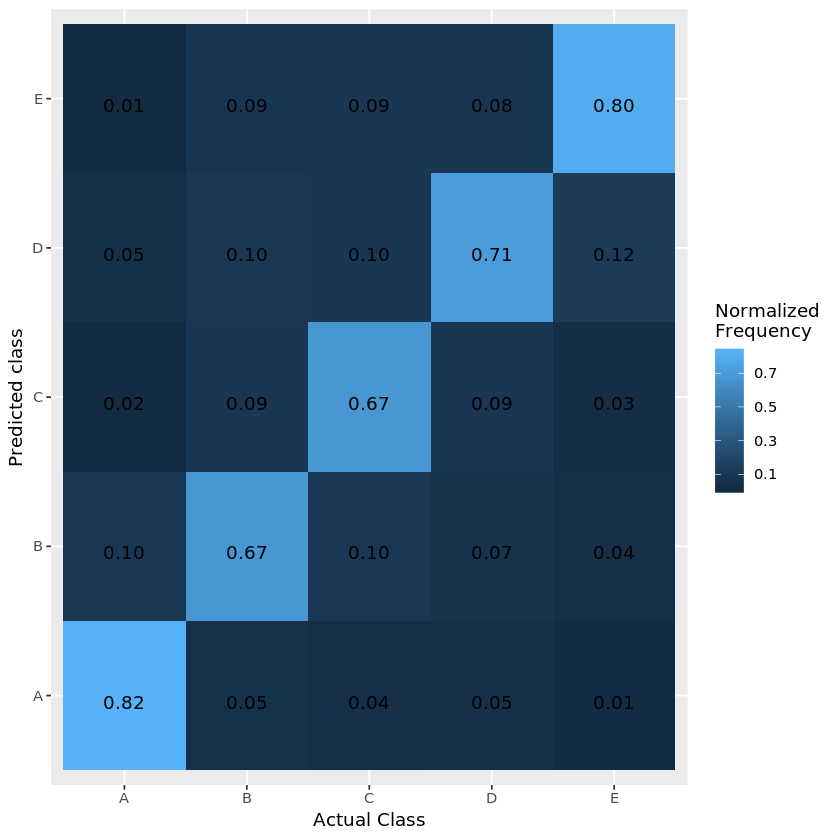

In [25]:
# Training
start_time <- Sys.time()
fit_dt <- train(classe ~ ., data=tr4trp, method="rpart", trControl=trainControl(method="none"), tuneGrid=data.frame(cp=0.01))
Sys.time() - start_time
# Validating
confusionMatrix(tr4valp$classe, predict(fit_dt, tr4valp))

conMtxPlot(confusionMatrix(tr4valp$classe, predict(fit_dt, tr4valp))$table)

## 6.2. Random forest

Time difference of 3.970982 mins

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1116    0    0    0    0
         B    1  756    2    0    0
         C    0    4  678    2    0
         D    0    0    9  633    1
         E    0    0    1    1  719

Overall Statistics
                                          
               Accuracy : 0.9946          
                 95% CI : (0.9918, 0.9967)
    No Information Rate : 0.2847          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9932          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9991   0.9947   0.9826   0.9953   0.9986
Specificity            1.0000   0.9991   0.9981   0.9970   0.9994
Pos Pred Value         1.0000   0.9960   0.9912   0.9844   0.9972
Neg Pred Value         0.9996   0.998

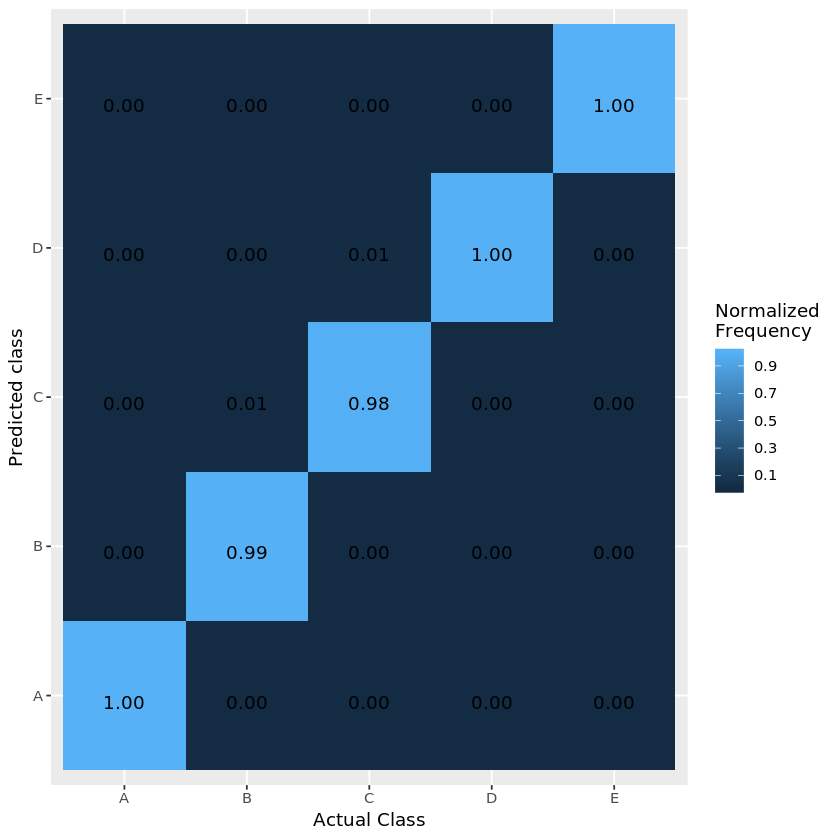

In [26]:
# Training
start_time <- Sys.time()
fit_rf_par_rs <- train(classe ~ ., data = tr4trp, method = "rf", trControl = fitControl)
Sys.time() - start_time

# Validaing
confusionMatrix(tr4valp$classe, predict(fit_rf_par_rs, tr4valp))

conMtxPlot(confusionMatrix(tr4valp$classe, predict(fit_rf_par_rs, tr4valp))$table)

## 6.3. GBM

Time difference of 1.582367 mins

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1095   17    3    1    0
         B   24  717   15    0    3
         C    0   24  658    2    0
         D    0    3   14  624    2
         E    1    7    6   11  696

Overall Statistics
                                          
               Accuracy : 0.9661          
                 95% CI : (0.9599, 0.9715)
    No Information Rate : 0.2855          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9571          
                                          
 Mcnemar's Test P-Value : 0.0001774       

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9777   0.9336   0.9454   0.9781   0.9929
Specificity            0.9925   0.9867   0.9919   0.9942   0.9922
Pos Pred Value         0.9812   0.9447   0.9620   0.9705   0.9653
Neg Pred Value         0.9911   0.983

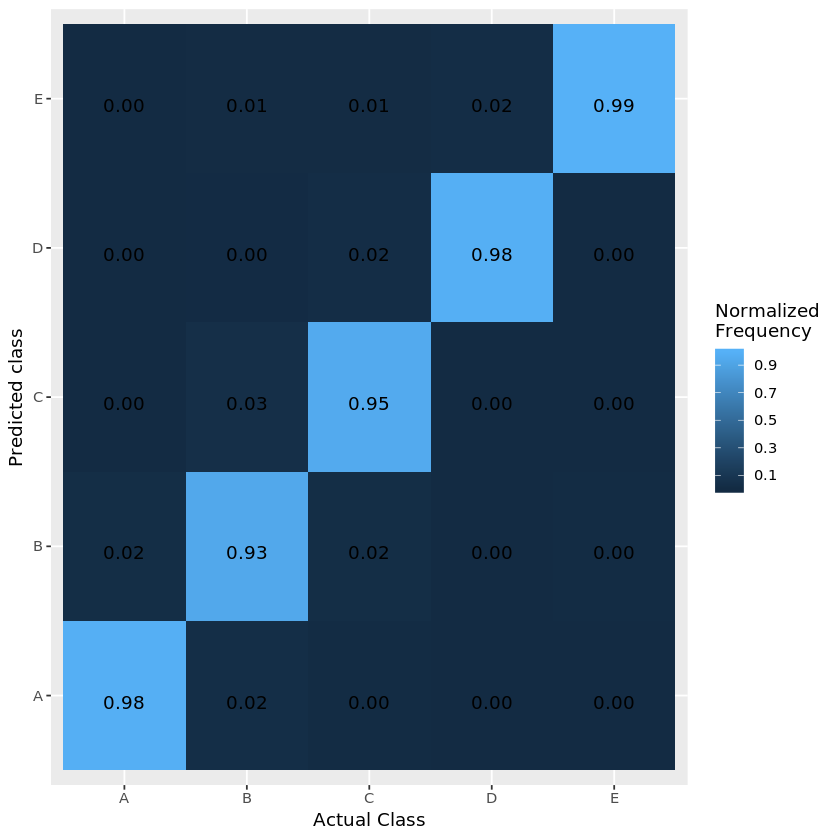

In [27]:
# Training
start_time <- Sys.time()
fit_gbm_rs <- train(classe ~ ., data = tr4trp, method="gbm", verbose=FALSE, trControl = fitControl)
Sys.time() - start_time

# Validation
confusionMatrix(tr4valp$classe, predict(fit_gbm_rs, tr4valp))

conMtxPlot(confusionMatrix(tr4valp$classe, predict(fit_gbm_rs, tr4valp))$table)

## 6.4. Interpretation

Comparing the 3 methods, below is the summary Decision tree, Random forest and GBM are respectively:

|                   | Decision Tree | Random Forest | GBM   |
|-------------------|---------------|---------------|-------|
|Validation accuracy|   74%         |   99%         |  96%  |
|Time               |  1.3 sec      | 4 min.        |1.5 min|

Based from this result, the Random forest is the most robust method. However it is the most time consuming one compared to Decision tree and GBM.

For demonstration purpose, the next step of my analysis is apply PCA on the best 2 methods (RF and GBM), then train the models again to see how they perform.

# 7. Train and validate Random forest and GBM with PCA

## 7.1. PCA processing

In [28]:
preprocessPCA <- preProcess(tr4tr[,-53], method = "pca", thresh = 0.9)
preprocessPCA

Created from 11775 samples and 52 variables

Pre-processing:
  - centered (52)
  - ignored (0)
  - principal component signal extraction (52)
  - scaled (52)

PCA needed 20 components to capture 90 percent of the variance

In [29]:
trainPCA <- predict(preprocessPCA, tr4tr[,-53])
valPCA <- predict(preprocessPCA,tr4val[,-53])
testPCA <- predict(preprocessPCA,tr4test[,-53])

PCA result suggests that with 90% variance coverage, it requires only 20 principle components (instead of 52 variables) for training.

## 7.2. Random forest

In [30]:
fit_pca_rf <- train(tr4tr$classe, method = "rf", verbose=FALSE, x=trainPCA, trControl = fitControl)
confusionMatrix(tr4val$classe, predict(fit_pca_rf, valPCA))

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1105    3    4    4    0
         B    9  739   10    1    0
         C    1   11  658   11    3
         D    1    0   21  619    2
         E    1    2    7    5  706

Overall Statistics
                                          
               Accuracy : 0.9755          
                 95% CI : (0.9702, 0.9801)
    No Information Rate : 0.2847          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.969           
                                          
 Mcnemar's Test P-Value : 0.08227         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9893   0.9788   0.9400   0.9672   0.9930
Specificity            0.9961   0.9937   0.9919   0.9927   0.9953
Pos Pred Value         0.9901   0.9736   0.9620   0.9627   0.9792
Neg Pred Value         0.9957   0.994

## 7.3. GBM

In [31]:
fit_pca_gbm <- train(tr4tr$classe, method="gbm", verbose=FALSE, x=trainPCA, trControl = fitControl)
confusionMatrix(tr4val$classe,predict(fit_pca_gbm, valPCA))

Confusion Matrix and Statistics

          Reference
Prediction   A   B   C   D   E
         A 962  33  45  64  12
         B  73 573  59  30  24
         C  46  49 537  35  17
         D  31  21  64 510  17
         E  25  57  52  43 544

Overall Statistics
                                          
               Accuracy : 0.7968          
                 95% CI : (0.7839, 0.8093)
    No Information Rate : 0.2898          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.743           
                                          
 Mcnemar's Test P-Value : 6.231e-14       

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.8461   0.7817   0.7094   0.7478   0.8860
Specificity            0.9447   0.9417   0.9536   0.9590   0.9465
Pos Pred Value         0.8620   0.7549   0.7851   0.7932   0.7545
Neg Pred Value         0.9377   0.9494   0.9321   0.9476   0.9781
P

## 7.4. Interpretation

The results show that with more than half of the features, running time is reduced, but the validation accuracy is also reduced to 97% and 80% accordingly.

In reality, the selection between Random forest with or without PCA depends on the project (sample size, model update requirement…). For this project, and even when I didn’t perform any deep parameter tuning, I pick Random forest without PCA as my final model.

_The next cell turns off parallel processing._

In [32]:
stopCluster(cluster)
registerDoSEQ()

# 8. Prediction on Test set

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1114    1    0    0    0
         B    5  749    5    0    0
         C    0    5  677    2    0
         D    0    0   11  630    2
         E    0    0    1    2  718

Overall Statistics
                                         
               Accuracy : 0.9913         
                 95% CI : (0.9879, 0.994)
    No Information Rate : 0.2853         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.989          
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9955   0.9921   0.9755   0.9937   0.9972
Specificity            0.9996   0.9968   0.9978   0.9960   0.9991
Pos Pred Value         0.9991   0.9868   0.9898   0.9798   0.9958
Neg Pred Value         0.9982   0.9981   0.994

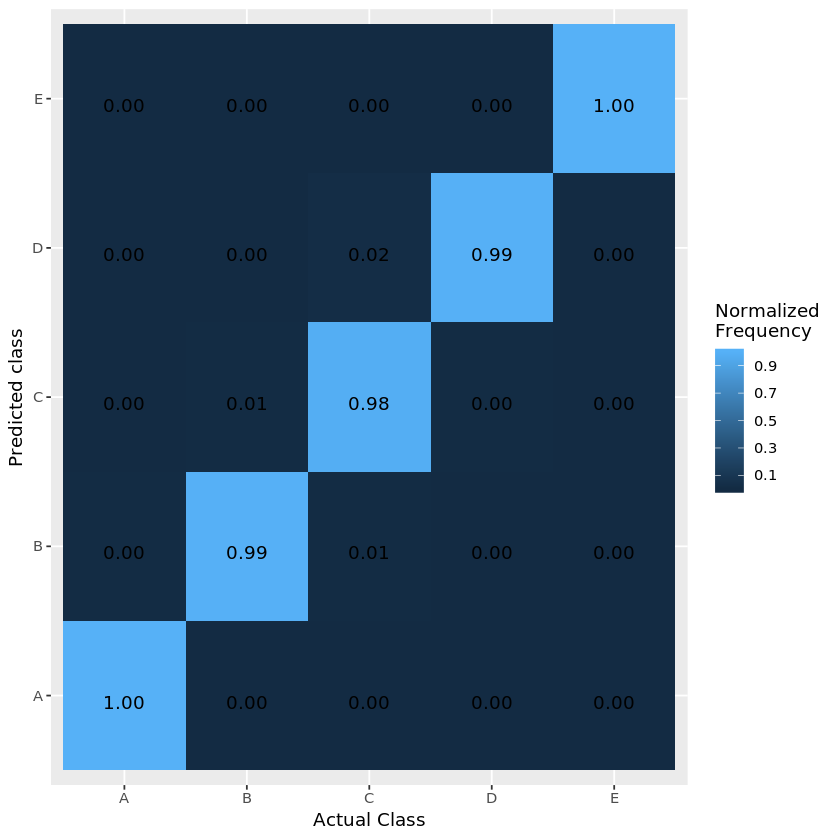

In [33]:
confusionMatrix(tr4testp$classe, predict(fit_rf_par_rs, tr4testp))
conMtxPlot(confusionMatrix(tr4testp$classe, predict(fit_rf_par_rs, tr4testp))$table)

The confusion matrix shows that the trained RF works well on the test set with similar accuracy compared to the validation. This indicates a good model, not overfitting.


|        | Validation set | Test set |
|--------|----------------|----------|
|Accuracy|   99%          |   99%    |